In [ ]:
!git clone --recurse-submodules https://github.com/JandJane/DialogueActClassification.git

In [ ]:
!unzip DialogueActClassification/swda/swda.zip -d DialogueActClassification/swda/swda

In [ ]:
!pip install -r DialogueActClassification/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import torch
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from tqdm import tqdm

import sys
sys.path.append('DialogueActClassification')

from dialogue_classification.dataset_utils import load_swda_corpus_data
from dialogue_classification.dataset import BertDataset
from dialogue_classification.models import DialogueNetBert
from dialogue_classification.train_test_split import train_set_idx, valid_set_idx, test_set_idx
from dialogue_classification.training import train_model

## Prepare data

In [3]:
talks, talk_names, tag_indices, tag_occurances = load_swda_corpus_data('DialogueActClassification/swda/swda/swda')

Loading SwDA Corpus...

Found 43 different utterance tags.

Loaded SwDA Corpus.


In [4]:
len(talks), len(tag_indices)

(1155, 43)

In [5]:
texts, labels = [], []
for text, label in talks:
    assert len(text) == len(label)
    text = [' '.join(utterance) for utterance in text]
    texts.append(text)
    labels.append(label)

## Bert Tokenize

In [6]:
max_length = 30

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False, model_max_length=max_length)


In [8]:
input_ids, attention_masks = [], []
for text in tqdm(texts):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    input_ids.append(encoded_input['input_ids'])
    attention_masks.append(encoded_input['attention_mask'])    

100%|██████████| 1155/1155 [00:39<00:00, 29.49it/s]


In [9]:
for i in range(len(input_ids)):
    if input_ids[i].size(1) < max_length:
        padding_shape = (input_ids[i].size(0), max_length - input_ids[i].size(1))
        input_ids[i] = torch.cat((input_ids[i], torch.zeros(padding_shape)), axis=1)
        attention_masks[i] = torch.cat((attention_masks[i], torch.zeros(padding_shape)), axis=1)

In [10]:
dialogue_lengths = [len(dialogue) for dialogue in input_ids]
dialogue_lengths = torch.LongTensor(dialogue_lengths)

input_ids = pad_sequence(input_ids, batch_first=True)
attention_masks = pad_sequence(attention_masks, batch_first=True)

labels = [torch.LongTensor(label) for label in labels]
y = pad_sequence(labels, batch_first=True)

In [11]:
dialogue_lengths.shape, input_ids.shape, attention_masks.shape, y.shape

(torch.Size([1155]),
 torch.Size([1155, 540, 30]),
 torch.Size([1155, 540, 30]),
 torch.Size([1155, 540]))

## Training

In [12]:
train_idx = np.isin(talk_names, train_set_idx)
valid_idx = np.isin(talk_names, valid_set_idx)
test_idx = np.isin(talk_names, test_set_idx)

In [13]:
train_set = BertDataset(input_ids[train_idx], attention_masks[train_idx], dialogue_lengths[train_idx], y[train_idx])
valid_set = BertDataset(input_ids[valid_idx], attention_masks[valid_idx], dialogue_lengths[valid_idx], y[valid_idx])
test_set = BertDataset(input_ids[test_idx], attention_masks[test_idx], dialogue_lengths[test_idx], y[test_idx])

In [14]:
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [15]:
net = DialogueNetBert(
    input_size=768, 
    output_size=len(tag_occurances), 
    rnn_hidden_size=128, 
    use_layer_norm=True, 
    max_utterance_len=max_length,
    bert_layers_to_finetune=2,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

[EPOCH 0] Train loss: 1.5384115226685056
[EPOCH 0] Val loss: 0.9672927260398865, F1-score: 0.7241072311801365
[EPOCH 0] Test loss: 1.037269651889801, F1-score: 0.6883030571555162
[EPOCH 1] Train loss: 0.8437608499375601
[EPOCH 1] Val loss: 0.7423100045749119, F1-score: 0.7734691858739737
[EPOCH 1] Test loss: 0.7831990420818329, F1-score: 0.7494461674789543
[EPOCH 2] Train loss: 0.7110395535590157
[EPOCH 2] Val loss: 0.6734299489430019, F1-score: 0.7839548916806804
[EPOCH 2] Test loss: 0.7175270617008209, F1-score: 0.765618077093487
[EPOCH 3] Train loss: 0.6344521783647084
[EPOCH 3] Val loss: 0.630747880254473, F1-score: 0.7973093283212979
[EPOCH 3] Test loss: 0.693562775850296, F1-score: 0.7718210013291982
[EPOCH 4] Train loss: 0.6148228995383732
[EPOCH 4] Val loss: 0.6239386882100787, F1-score: 0.7951825106340885
[EPOCH 4] Test loss: 0.6965798139572144, F1-score: 0.7684980062029241
[EPOCH 5] Train loss: 0.6022709210713705
[EPOCH 5] Val loss: 0.6173247694969177, F1-score: 0.79721040656

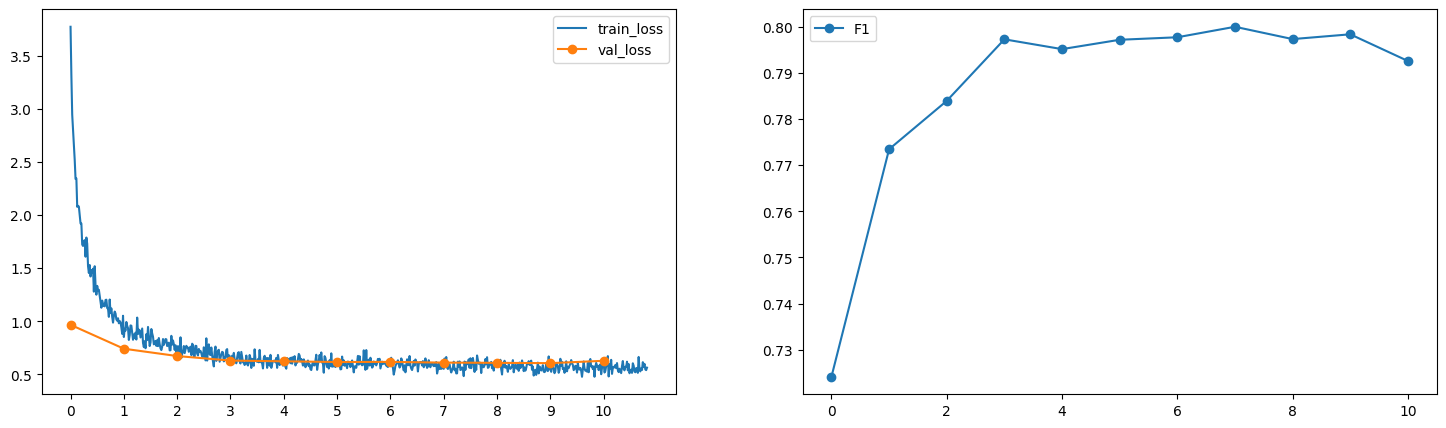

In [17]:
train_model(net, train_loader, valid_loader, test_loader, optimizer,
            bert_finetuning_epochs=3, n_epochs=100, verbose=True, plot=True)